In [2]:
# -- coding: utf-8 --
import os
import numpy as np
import pandas as pd
import anndata as ad
import numpy as np
import scanpy as sc
import time
import matplotlib.pyplot as plt
import scvelo as scv
from TSvelo.TSvelo_utils import analyze_g, analyze_GO_KEGG

dataset_name = 'gastrulation_erythroid' 
save_folder = 'TSvelo_' + dataset_name + '/'
adata = ad.read_h5ad(save_folder +"/TSvelo.h5ad")
print(adata)


AnnData object with n_obs × n_vars = 9815 × 181
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'clusters', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'leiden', 't_ini', 't_0', 't_steps', 'velocity_self_transition', 'velocity_length', 'velocity_confidence_transition', 'velocity_consistency', 't'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'n_TFs', 'g_select_metric', 'non_sparse_rate', 'selected_genes', 'to_reserve', 'beta', 'gamma', 'W_bias', 'loss'
    uns: 'S_t', 'U_t', 'all_TFs', 'all_TFs_used', 'celltype_colors', 'clusters_colors', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'loss_mask', 'neighbors', 'paga', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'TFs', 'TFs_correlation', 'TFs_id', 'TFs_times', 'W'
    layers: 'Ms'

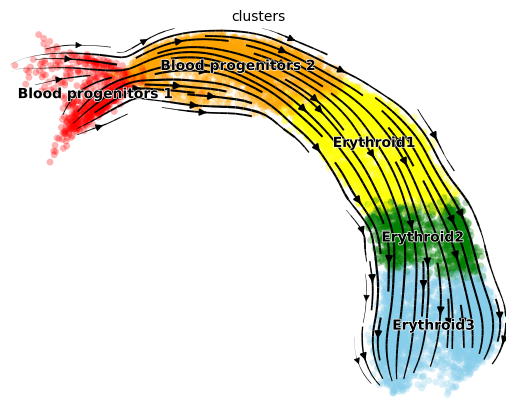

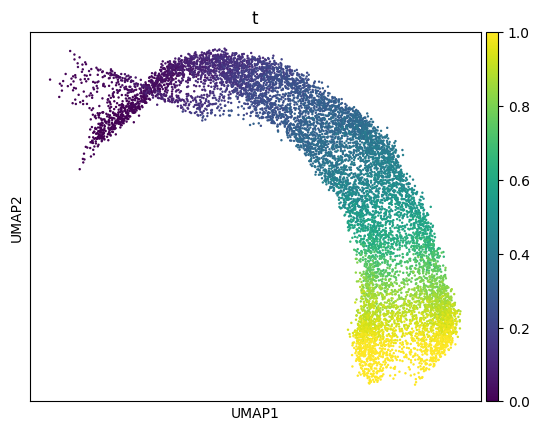

In [4]:
scv.pl.velocity_embedding_stream(adata, vkey='velocity')
sc.pl.umap(adata, color='t')

Drawing HBA-X


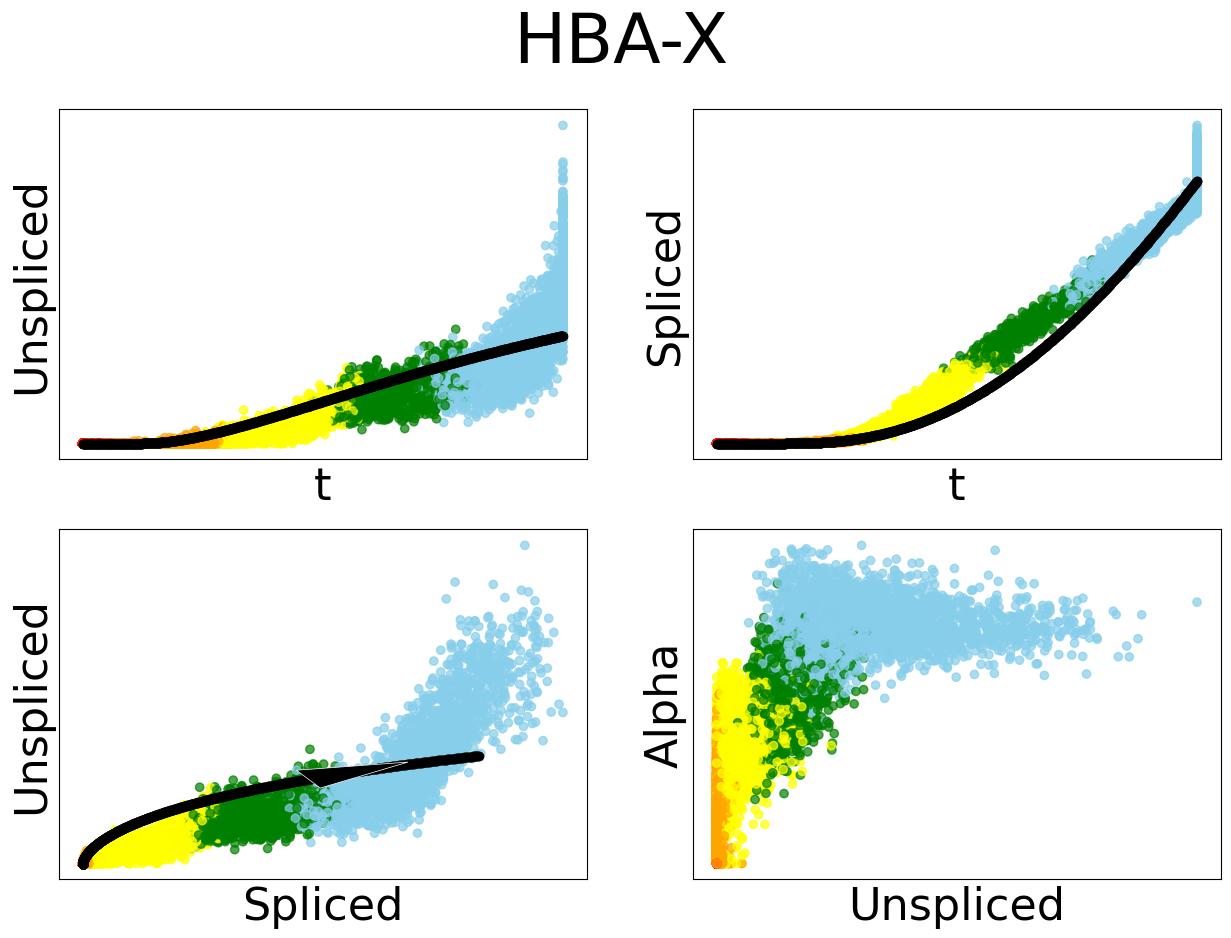

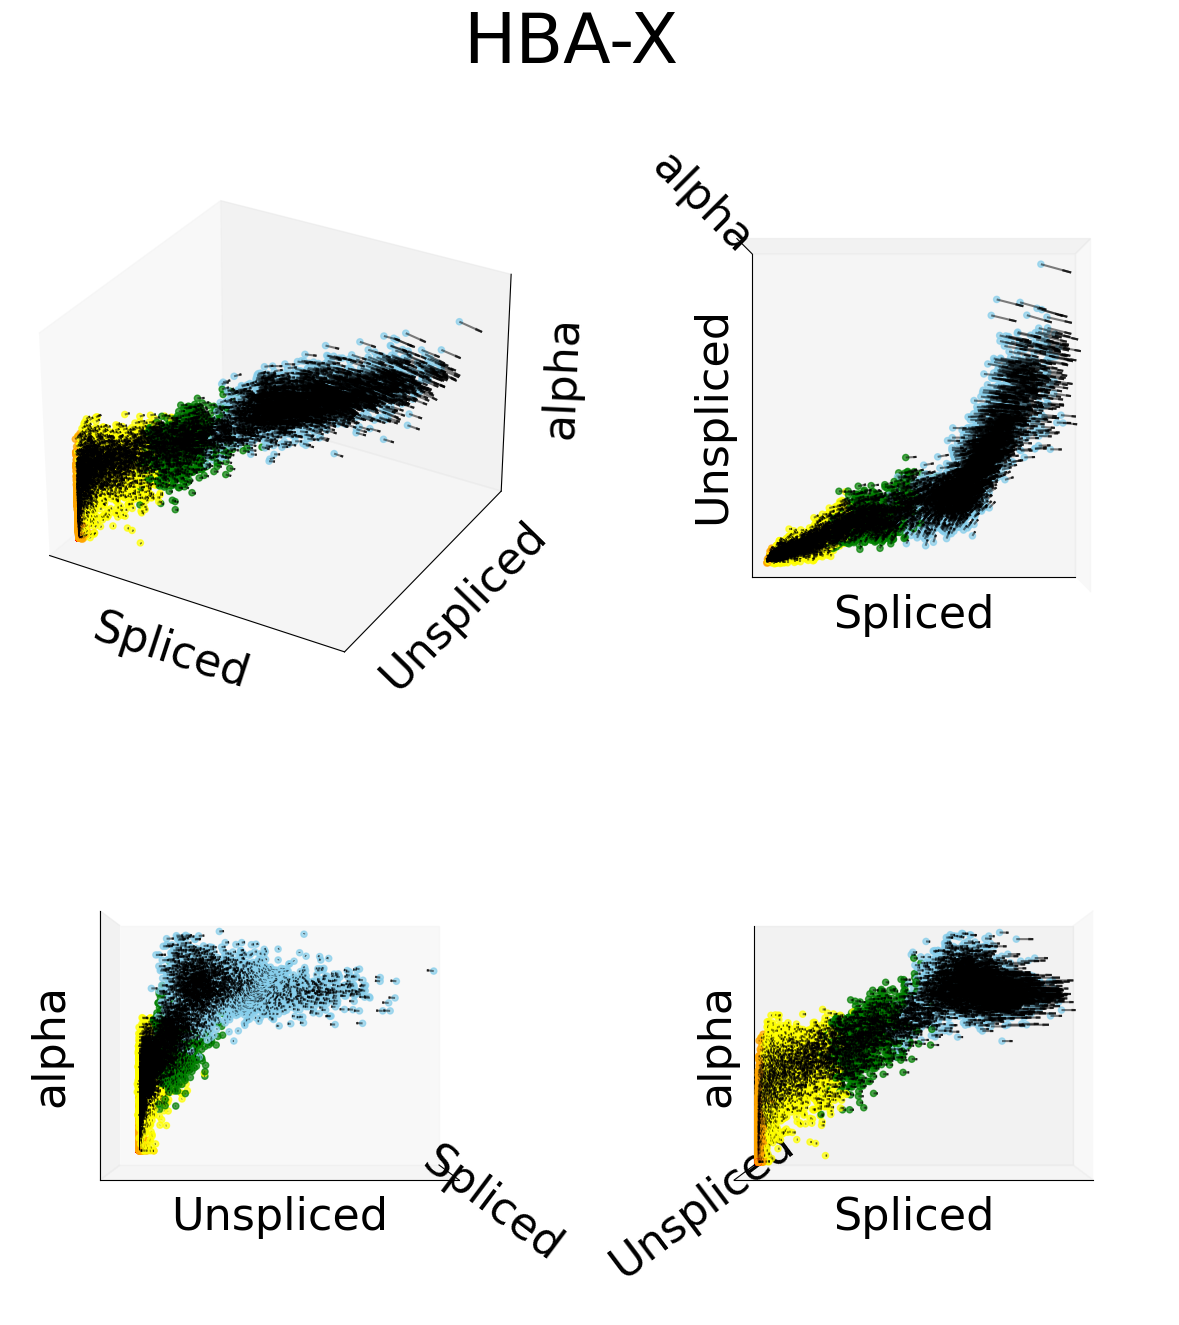

Drawing HBA-X


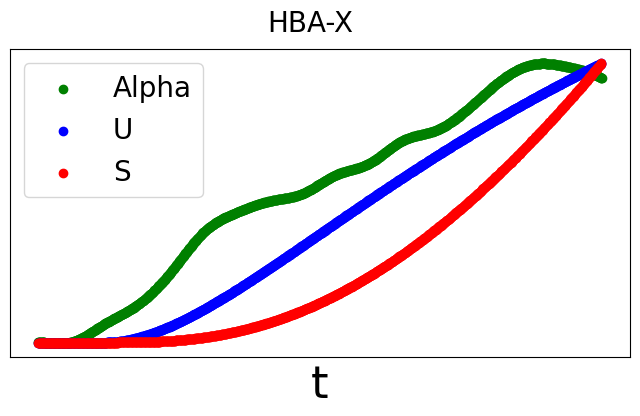

Drawing SLC25A21


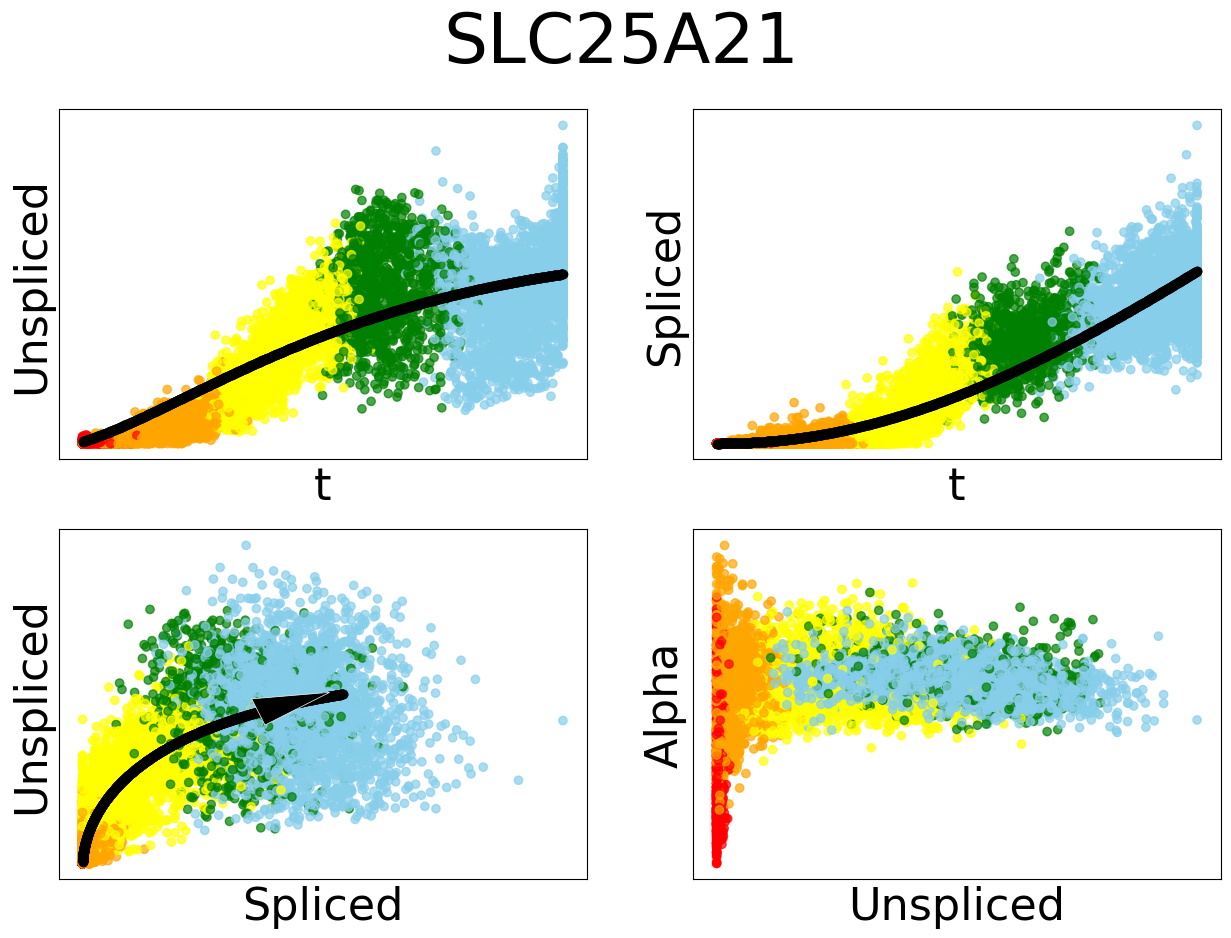

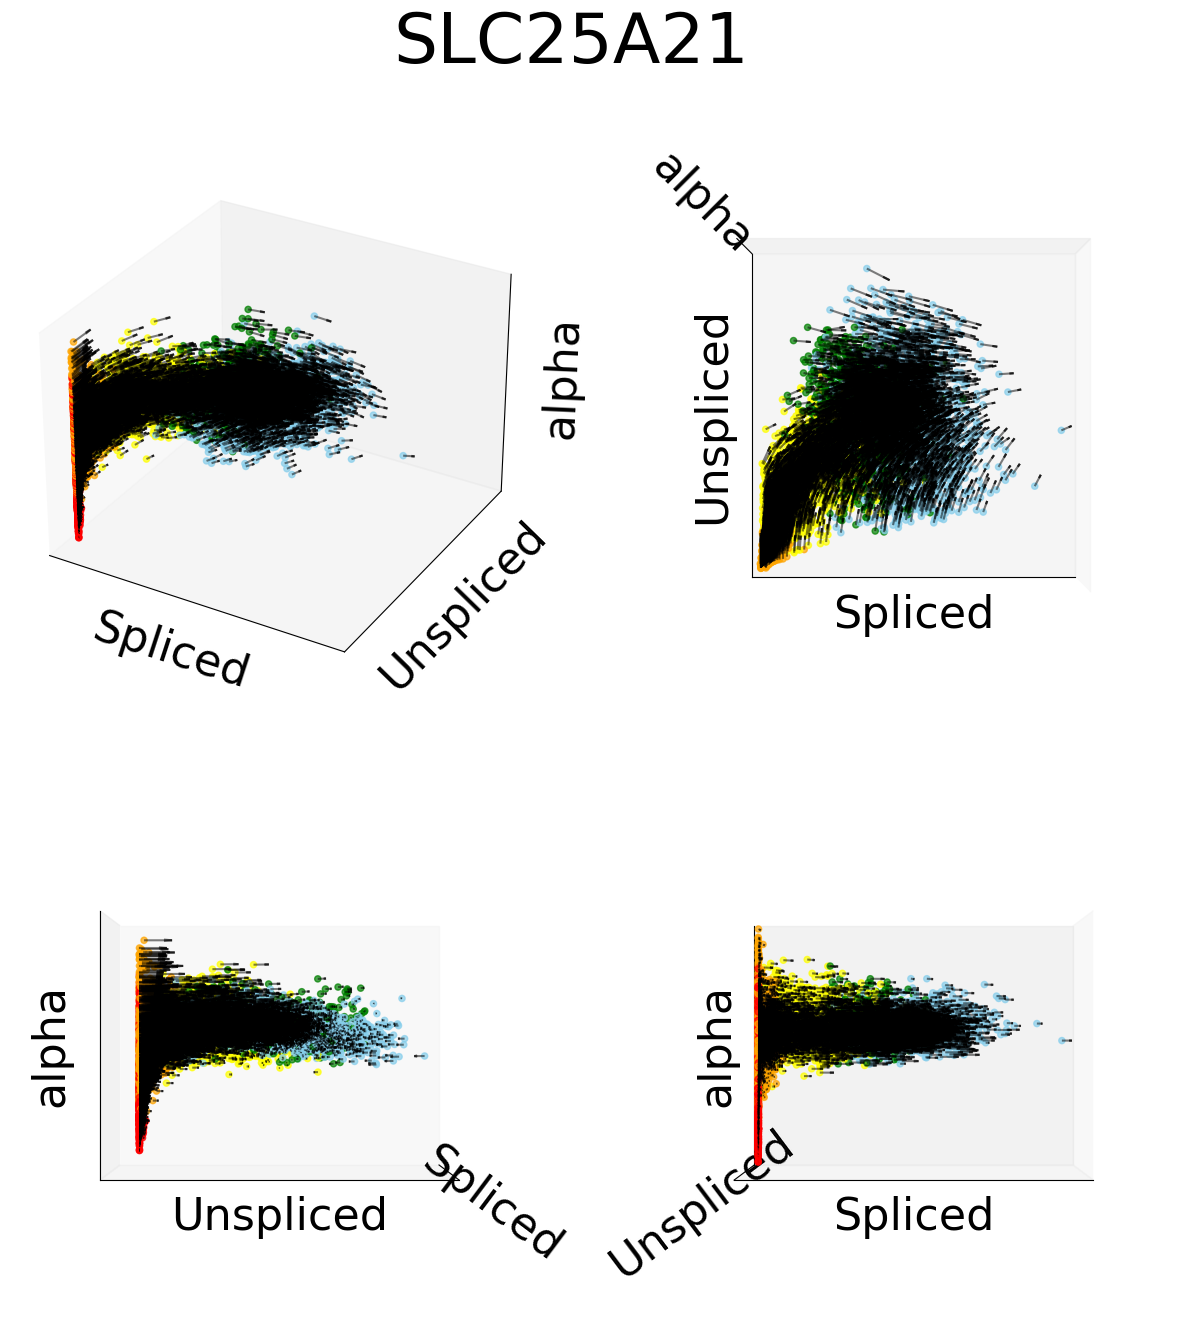

Drawing SLC25A21


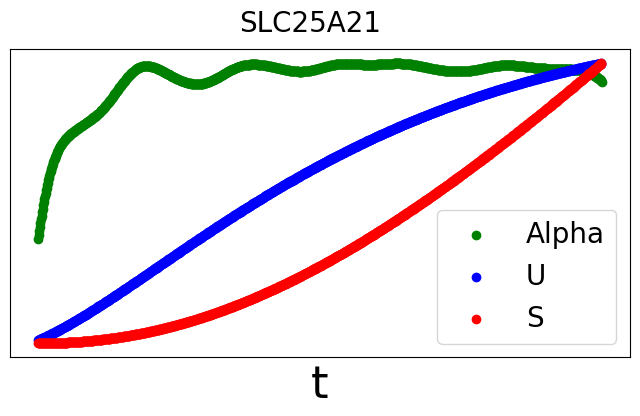

Drawing ABCG2


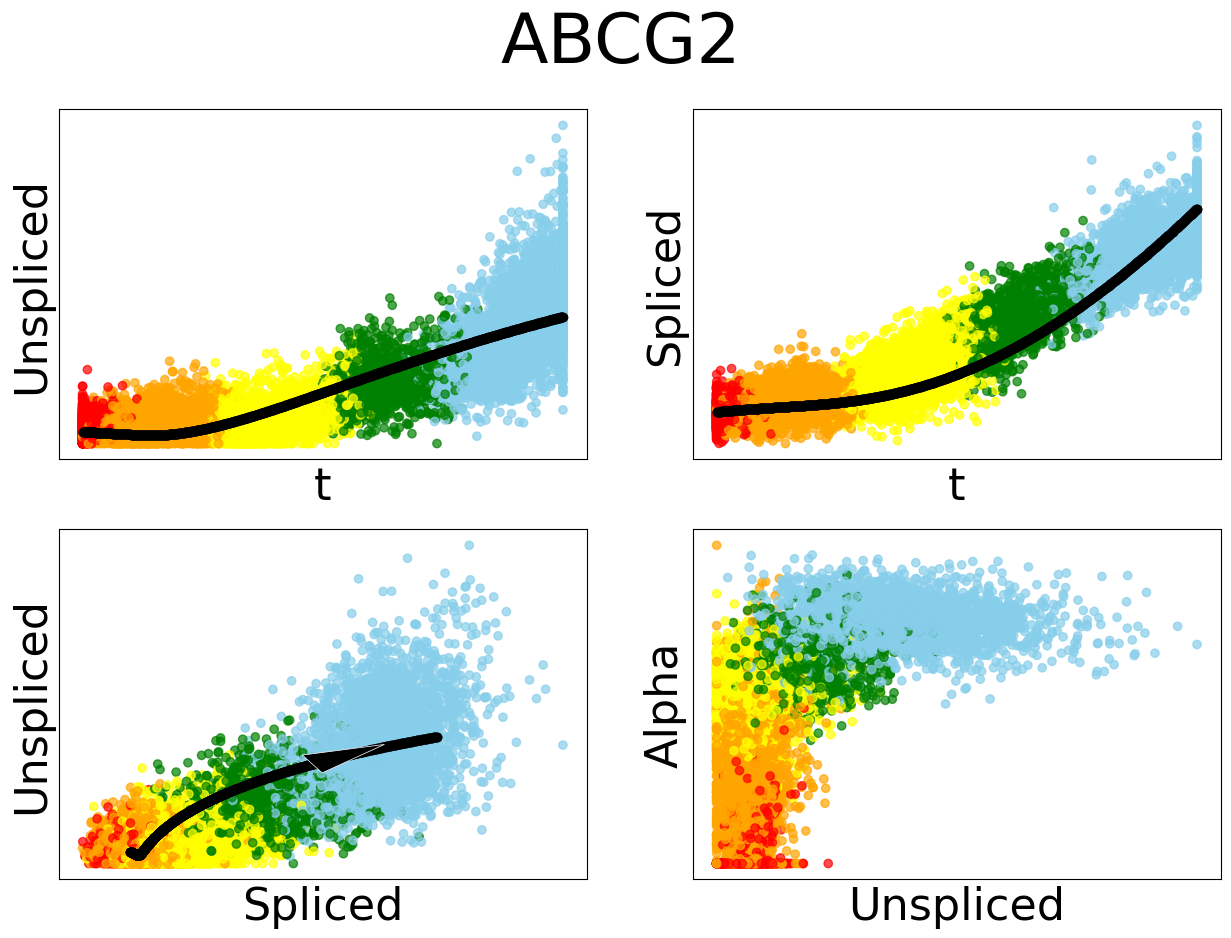

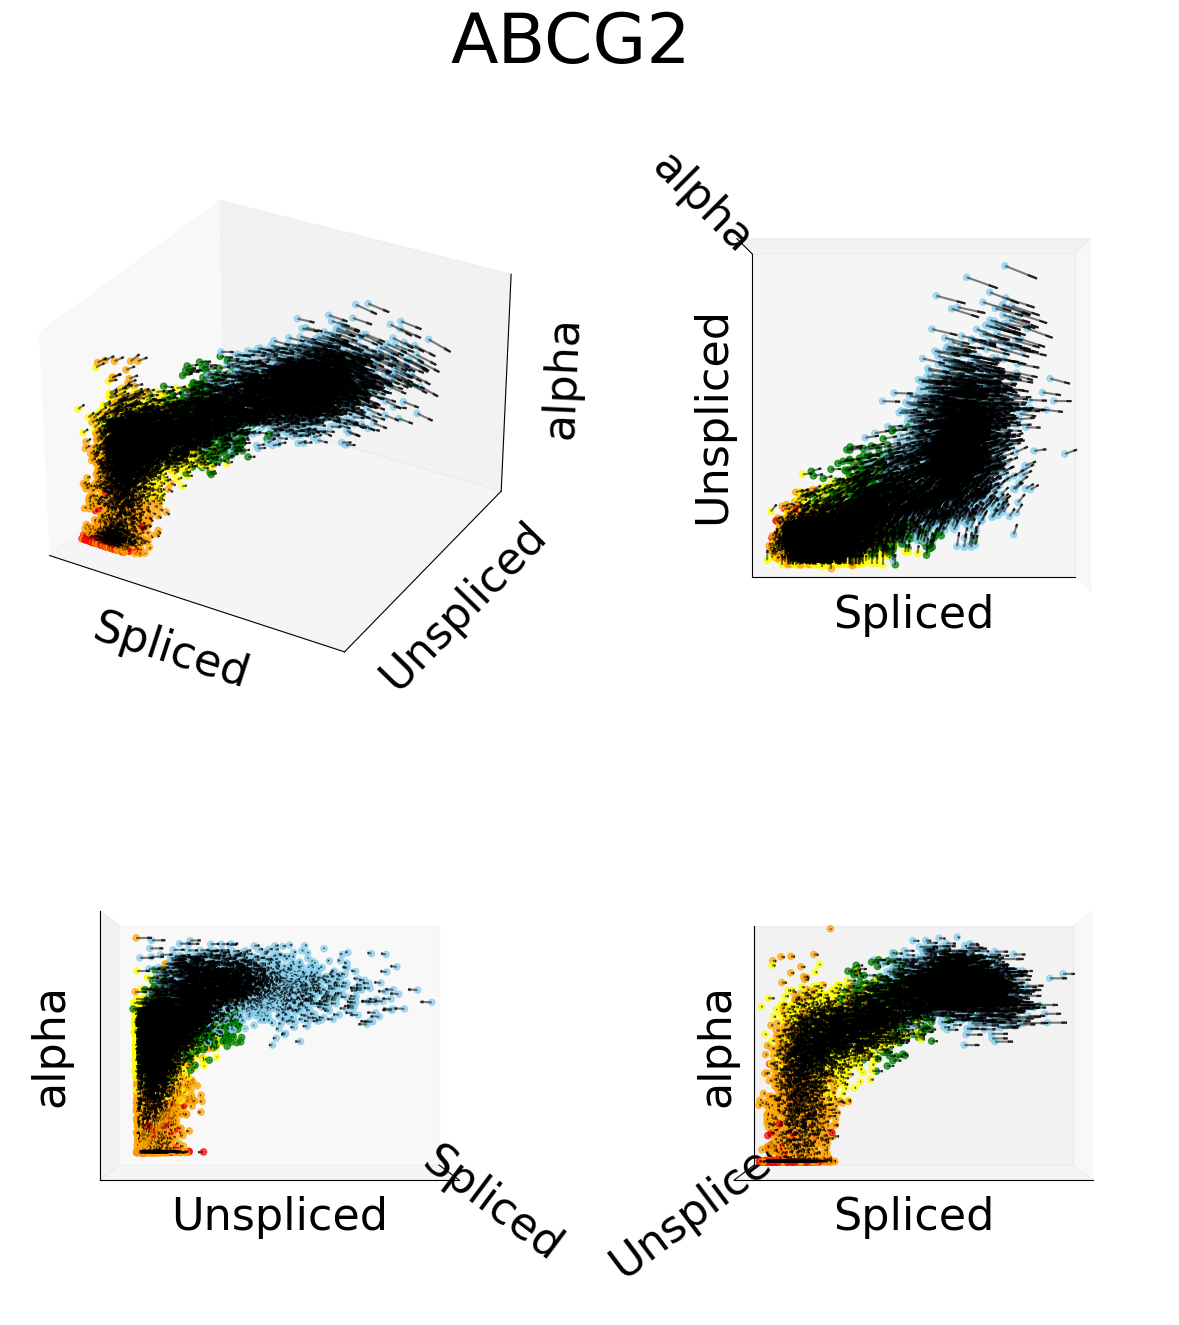

Drawing ABCG2


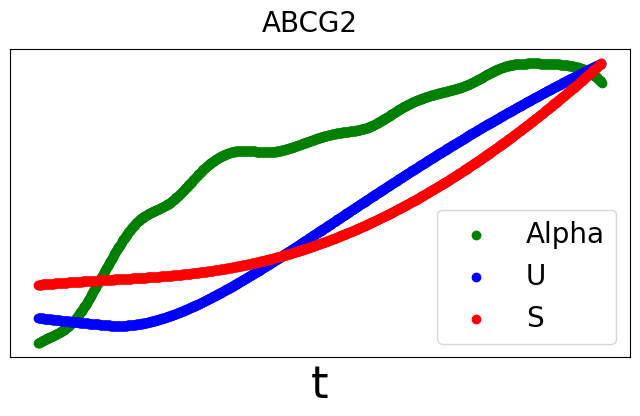

In [2]:
sorted_var_names = adata[:, adata.var['selected_genes']==True].var['loss'].sort_values().index
for g in sorted_var_names[:3]:
    g_id = list(adata.var_names).index(g)
    analyze_g(adata, g, to_show=1)

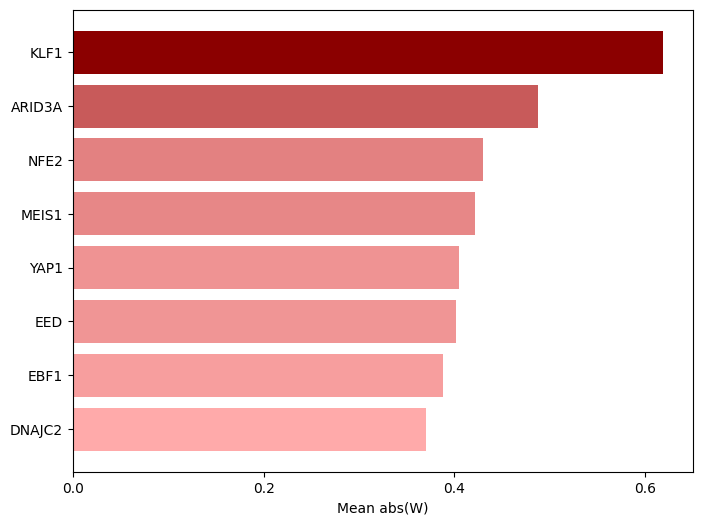

In [3]:
def get_W_df(adata):
    df_list = []
    for g_id, g in enumerate(adata.var_names):
        W_g = adata.varm['W'][g_id]
        #expression_g = adata.layers['Ms'][:,g_id].mean()
        df_g = pd.DataFrame({g: W_g}, adata.var_names)
        df_list.append(df_g)
        
    df = pd.concat(df_list, axis=1)
    df = df[(df != 0).any(axis=1)]

    df_abs = df.abs() 
    row_mean = df_abs.apply(lambda x: x[x != 0].mean(), axis=1)
    row_count = df.apply(lambda row: (row.abs() > 0.).sum(), axis=1)
    df_row = pd.DataFrame({'Mean abs(W)': row_mean, 'target counts': row_count})
    df_row = df_row.sort_values(by='Mean abs(W)', ascending=False)
    return df, df_row

def show_TFs_weight(df, key='Mean abs(W)'):
    from matplotlib.colors import LinearSegmentedColormap
    plt.figure(figsize=(8, 6))  
    norm = plt.Normalize(df[key].min(), df[key].max())  
    red_colors = ["#FFAAAA", "#8B0000"]  # reds
    red_cmap = LinearSegmentedColormap.from_list("red_gradient", red_colors)
    df_sorted = df.sort_values(key, ascending=True)
    colors = []
    for val in df_sorted[key]:
        colors.append(red_cmap(norm(val)))
    
    bars = plt.barh(df_sorted.index, df_sorted[key], color=colors)
    
    plt.rcParams.update({'font.size': 32})
    plt.xlabel(key)
    plt.show()
    return

W_df, W_df_row = get_W_df(adata)

show_TFs_weight(W_df_row[:8], key='Mean abs(W)')

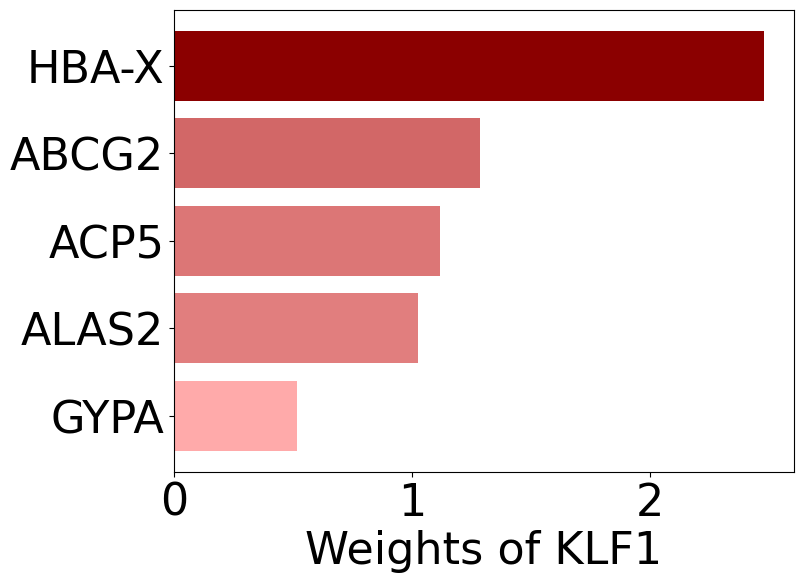

In [4]:
TF = 'KLF1'
key = 'Weights of ' + TF
df = pd.DataFrame(W_df.loc[[TF]].values[0], index=W_df.loc[[TF]].columns, columns=[key])
df = df.sort_values(by=key, ascending=False) 
show_TFs_weight(df[:5], key=key)


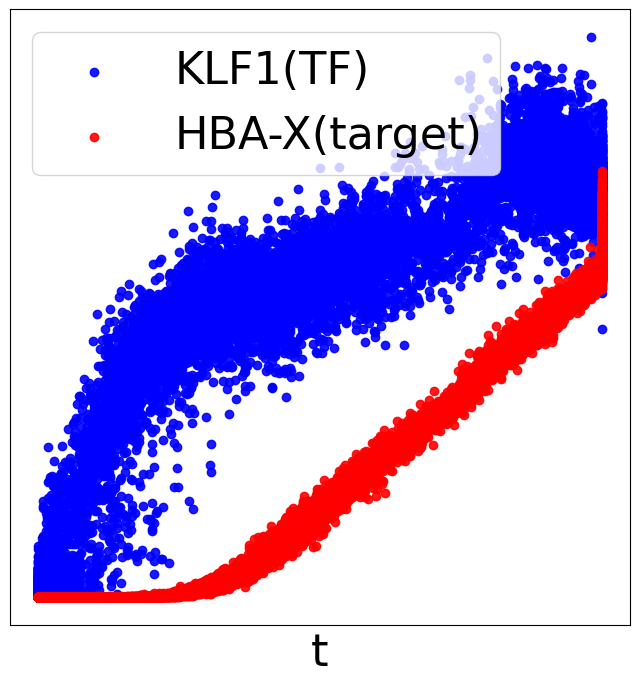

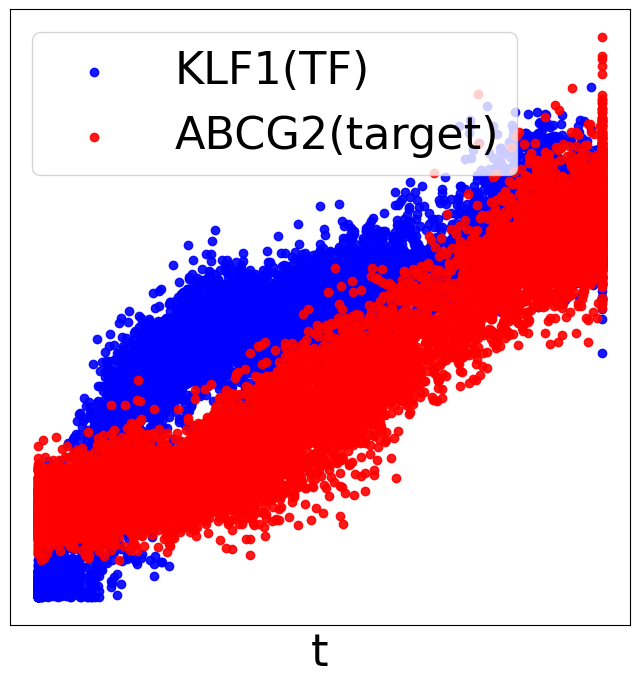

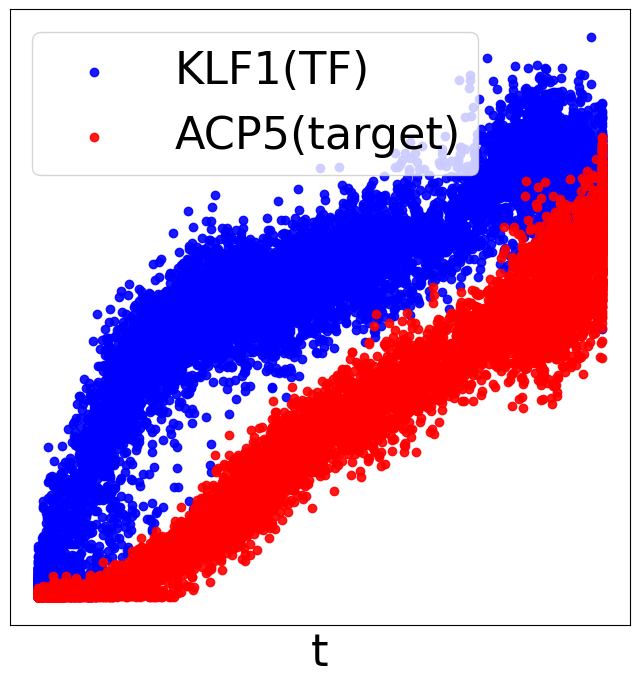

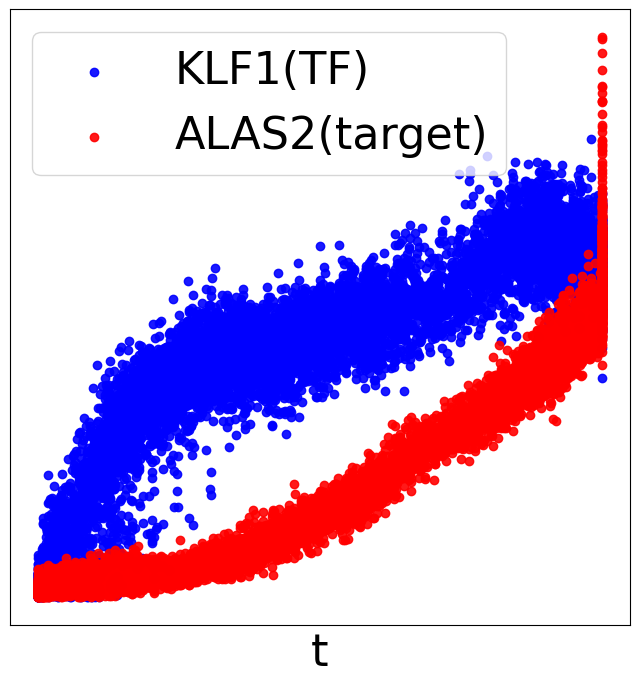

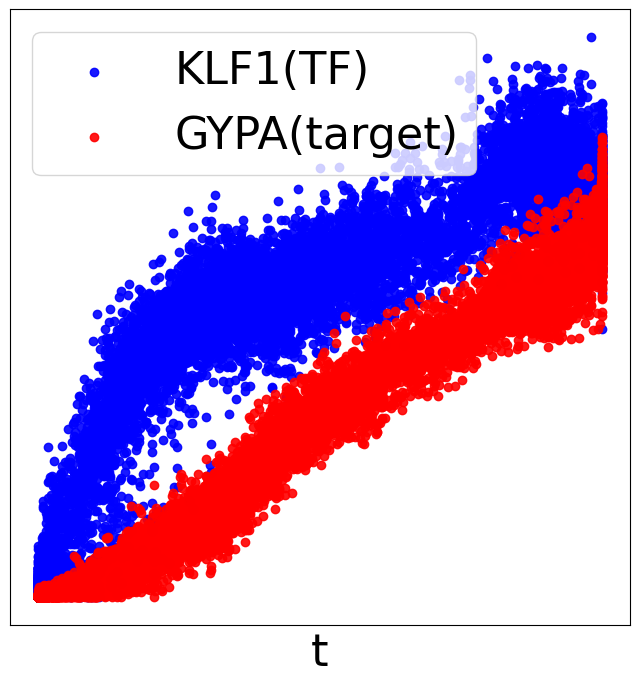

In [5]:
def plot_coexpression(adata, gene1, gene2):
    gene1_expression = adata[:, gene1].layers['S']
    gene2_expression = adata[:, gene2].layers['S']
    t = adata.obs['t']
    plt.figure(figsize=(8, 8))
    plt.scatter(t, gene1_expression, label=gene1+'(TF)', alpha=0.9, color='b')
    plt.scatter(t, gene2_expression, label=gene2+'(target)', alpha=0.9, color='r')
    plt.xlabel('t')
    plt.legend()
    plt.xticks([])
    plt.yticks([])
    plt.show()

    return

gene1 = 'KLF1'
for gene2 in ['HBA-X', 'ABCG2', 'ACP5',  'ALAS2', 'GYPA']:
    plot_coexpression(adata, gene1, gene2)

In [6]:
#selected_genes = list(adata[:,adata.var['selected_genes']].var_names)
#analyze_GO_KEGG(selected_genes, background=None, save_name='selected_genes')
